<span id="contents"></span>
## Contents

1. Kernel Ridge Regression (KRR)
  1. Reproducing kernel Hilbert spaces (RKHS)
  2. [Problem formulation](#KRRproblemformulation)
  3. [Solution](#KRRsolution)
  4. [Computational complexity](#Computationalcomplexity)
2. Subset of Regressors/ Nystrom
  1. [Problem formulation](#SoR)
  2. [Solution](#SoRSolution)
3. Optimized Kernel Ridge Regression (OKRR$^*$)
  1. [Problem formulation](#okrr)
  2. Solution**S**:
    1. [Gradient descent](#GD)
    2. [Stochastic gradient descent](#SGD)
    3. [Exact $\alpha$](#alpha_exact)
4. [Gaussian processes $\mathcal{GP}$s](#gps)
  1. [$\mathcal{GP}s$ vs KRR](#gpvskrr)
5. [Sparse $\mathcal{GP}$s. ($\mathcal{SPGP}$)](#spgp):
  1. Formulation: SoR, FITC,DTC.
  2. [VFE](#vfe)
  3. [$\mathcal{SPGP}s$ vs OKRR$^*$](#spgpvsokrr)
6. [Preliminary results](#results)

## KRR and $\mathcal{GP}s$ 

$\mathcal{D}=(X,y)$. $X$ is $N\times D$. $y$ is $N \times 1$. 

Computational complexity of computing $\alpha^* = (K+\lambda I)^{-1} y$:

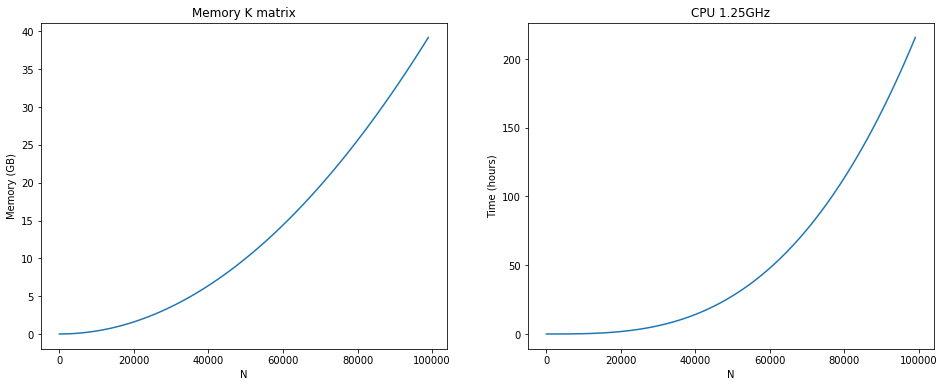

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = np.arange(0,10**5,1000)

size_element = 8 #bytes
Memory_GB = size_element*N**2/10**9/2

power_gpu_GHz = 1.25
operations_per_second_cpu = power_gpu_GHz*10**9 #1.25GHz
time_hours = (N**3/operations_per_second_cpu) / 3600

fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(N,Memory_GB)
ax[1].plot(N,time_hours)
ax[0].set_xlabel("N")
ax[0].set_ylabel("Memory (GB)")
ax[0].set_title("Memory K matrix")
ax[1].set_xlabel("N")
ax[1].set_title("CPU %.2fGHz"%power_gpu_GHz)
_=ax[1].set_ylabel("Time (hours)")


$$
k(X,X)=K_{ff} = \begin{pmatrix} 
k(x_1,x_{1}) & k(x_1,x_{2}) &...& k(x_1,x_{N}) \\
k(x_2,x_{1}) & k(x_2,x_{2}) &...& k(x_2,x_{N}) \\
\vdots & \vdots & \ddots &\vdots \\
k(x_N,x_{1}) & k(x_N,x_{2}) &...& k(x_N,x_{N}) \\
\end{pmatrix} \in \mathbb{R}^{N\times N}
$$

## Preliminaries on **Reproducing kernel Hilbert Space (RKHS)**

<img src="https://media.giphy.com/media/KmTnUKop0AfFm/giphy.gif" width="600">

## Preliminaries on **(RKHS)**

Suppose we have a **kernel function** that measures *similarities* between points in our input space $\mathcal{X}$.

$$
\begin{aligned}
k: &\mathcal{X} \times \mathcal{X} \longrightarrow \mathbb{R}^{+}\\
   &(x,x')\longrightarrow  k(x,x')
\end{aligned}
$$

This kernel function defines a **Reproducing kernel Hilbert Space (RKHS)** [[Mercer 1907]](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space) that we will call $\mathcal{F}$. (By means of applying the [Moore–Aronszajn theorem](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space#Moore.E2.80.93Aronszajn_theorem)) 

* $\mathcal{F}$ is an *space of functions* $f\in \mathcal{F}$ is a function $f:\mathcal{X} \longrightarrow \mathbb{R}$. 

* This *space of functions* is formed by functions of the form $f(\color{blue}x)=\sum_{i=1}^\infty a_i k(x_i,\color{blue}x)$. (where $\sum_{i=1}^\infty a_i^2 k(x_i,x_i)< \infty$).

* **The scalar product** between two **functions** in this *space of functions* is computed as follows:
$$
\langle f,g \rangle_{\mathcal{F}} = \langle \sum_{i=1}^{\infty}a_i k(x_i,\cdot), \sum_{i=1}^{\infty}b_i k(y_i,\cdot)\rangle_{\mathcal{F}}:=\sum_{i=1}^\infty\sum_{j=1}^\infty a_i b_j k(x_i,y_j)
$$
* If $k$ is *cool* the space $\mathcal{F}$ is formed by all the *interesting* functions $f:\mathcal{X} \longrightarrow \mathbb{R}$

## Kernel functions
Input space $\mathcal{X}=\mathbb{R}^D$.
1. Kernel **RBF**: $\gamma$ is an scalar:$\gamma\in \mathbb{R}$.
$$
k(x,x') = exp\left(-\gamma\|x-x'\|^2\right)
$$
1. Kernel **ARD**: $\gamma$ is a vector: $\gamma\in \mathbb{R}^D$
$$
k(x,x') = exp\left(-\left\|\frac{x-x}{\gamma}'\right\|^2\right)
$$

<span id="KRRproblemformulation"> </span>
## KRR problem formulation

Let $\mathcal{D}=\{x_i,y_i\}_{i=1}^N$ be our data for our regression problem $x_i\in \mathcal{X}$ and $y_i \in \mathbb{R}$. **Kernel Ridge Regression (KRR)** aims to solve the problem:

$$
f^* = \arg \min_{\color{red}f \in \mathcal{F}} \underbrace{\overbrace{\sum_{i=1}^N \big( \color{red}f(x_i) - y_i \big)^2}^{Error(\color{red}f)} + \overbrace{\lambda\|\color{red}f\|^2_{\mathcal{F}}}^{Reg(\color{red}f)}}_{J(\color{red}f)}
$$

The [[Representer Theorem]](https://en.wikipedia.org/wiki/Representer_theorem) states that the $f^*$ minimum of $J(\color{red}f)$ can be **represented** as:
$$
f^*(\color{blue}x) = \sum_{i=1}^N\alpha_i k(x_i,\color{blue}x) = \overbrace{k(\color{blue}x,X)}^{1 \times N}\underbrace{\alpha}_{^{N \times 1}}
$$

## KRR problem formulation

The risk of $f^*$:

$$
\begin{aligned}
J(f^*) &= \sum_{i=1}^N \big(f^*(x_i) - y_i \big)^2 + \lambda\|f^*\|^2_{\mathcal{F}} \\
  &= \sum_{i=1}^N \big(k(x_i,X)\alpha - y_i \big)^2 + \lambda\sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j k(x_i,x_j) \\
  &= \|K \alpha - y \|^2 + \lambda\alpha^t K \alpha = J(\alpha)
\end{aligned}
$$

We transformed the minimization in the *space of functions* of the **RKHS of k** into a minimization problem (linear ridge regression actually) in $\alpha \in \mathbb{R}^N$!

What is the $\alpha^*$ that minimizes $J(\alpha)$?

<span id="KRRsolution"> </span>
## KRR solution

What is the $\alpha^*$ that minimizes $J(\alpha)$?

$$
\alpha^* = (K+ \lambda I)^{-1}y
$$


How do we make predictions for new $\color{purple}x$:
$$
f^*(\color{purple}x) = \sum_{i=1}^N\alpha_i^* k(x_i,\color{purple}x) = \overbrace{k(\color{purple}x,X)}^{1 \times N}\underbrace{\alpha^*}_{^{N \times 1}}
$$

What is the value of the risk, $J$ at $\alpha^*$?

$$
\begin{aligned}
J(\alpha^*) &=  \lambda y^t(K+\lambda I)^{-1} y \\
&=  y^t\left(\lambda^{-1}K+ I\right)^{-1} y 
\end{aligned}
$$


<center>
This term is familiar if you worked with the marginal likelihood of a $\mathcal{GP}$!
<center>

## Solving $\nabla_{\alpha}J(\alpha^*) = 0$

We first develop the Risk term:
$$
\begin{aligned}
J(\alpha) &= \|K \alpha - y \|^2 + \lambda\alpha^t K \alpha \\
 &= (K\alpha -y)^t (K\alpha -y) + \lambda\alpha^t K \alpha \\
 &= \alpha^t K^t K\alpha -2 \alpha^t K y + y^t y + \lambda\alpha^t K \alpha 
 \end{aligned}
$$

We compute the gradient:
$$
\begin{aligned}
\nabla_\alpha J(\alpha) &= 2 K K\alpha -2 K y + 2\lambda K \alpha  \\
&= 2 K \big( K\alpha - y + \lambda \alpha\big)  \\
&= 2 K \big( (K+ \lambda I) \alpha - y \big) 
\end{aligned}
$$


Now we just solve the system:
$\nabla_\alpha J(\alpha) = 0$ $\implies$ $(K+ \lambda I) \alpha - y = 0$  $\implies$ $\alpha^* = (K+ \lambda I)^{-1}y$

## $J(\alpha^*) = Error(\alpha^*) + Reg(\alpha^*)$
What is the training error ($Error(\color{red}f)$) that the minimum $\alpha^*$ incurs:
$$
\require{cancel}
\begin{aligned}
Error(\alpha^*) &= \|K\alpha^* -y\|^2 = \|K(K+\lambda I)^{-1}y - y\|^2 \\
&= \|( K+\lambda I -\lambda I)(K+\lambda I)^{-1}y - y\|^2 \\
&= \|\cancel{( K+\lambda I)(K+\lambda I)^{-1}}y -\lambda I(K+\lambda I)^{-1}y - y\|^2 \\
&= \|\cancel{y} -\lambda (K+\lambda I)^{-1}y - \cancel{y}\|^2 \\
&= \lambda^2 \| (K+\lambda I)^{-1}y\|^2 \\
&= \lambda^2 \| \alpha^* \|^2 
\end{aligned}
$$

## $J(\alpha^*) = Error(\alpha^*) + Reg(\alpha^*)$
What is the regularization penalty ($Reg(\color{red}f)$) of $\alpha^*$:
$$
\begin{aligned}
\frac{Reg(\alpha^*)}{\lambda} &= \alpha^{*t}K\alpha^* \\
&= y^t(K+\lambda I)^{-1}K(K+\lambda I)^{-1} y \\
&= y^t(K+\lambda I)^{-1}(K+\lambda I- \lambda I)(K+\lambda I)^{-1} y \\
&= y^t\cancel{(K+\lambda I)^{-1}}\cancel{(K+\lambda I)}(K+\lambda I)^{-1} y -y^t(K+\lambda I)^{-1}(\lambda I)(K+\lambda I)^{-1} y \\
&= y^t(K+\lambda I)^{-1} y -\lambda y^t(K+\lambda I)^{-1}(K+\lambda I)^{-1} y \\
&= y^t(K+\lambda I)^{-1} y -\lambda\|(K+\lambda I)^{-1} y \|^2 \\
&= y^t(K+\lambda I)^{-1} y -\lambda\|\alpha^* \|^2 \\
Reg(\alpha^*) &= \lambda y^t(K+\lambda I)^{-1} y -\lambda^2\|\alpha^* \|^2
\end{aligned}
$$


## $J(\alpha^*) = Error(\alpha^*) + Reg(\alpha^*)$

Putting things together:

$$
\begin{aligned}
J(f^*) = J(\alpha^*) &= Error(\alpha^*) + Reg(\alpha^*) \\
&= \cancel{\lambda^2 \| \alpha^* \|^2} + \lambda y^t(K+\lambda I)^{-1} y -\cancel{\lambda^2\|\alpha^* \|^2} \\
&= \lambda y^t(K+\lambda I)^{-1} y \\
&= \lambda y^t\left(\lambda\left(\lambda^{-1}K+ I\right)\right)^{-1} y \\
&=  y^t\left(\lambda^{-1}K+ I\right)^{-1} y 
\end{aligned}
$$
    

<span id="Computationalcomplexity"></span>
## Computational complexity
Computational complexity of computing $\alpha^* = (K+\lambda I)^{-1} y$:
* $\mathcal{O}(N^3)$ operations to compute $\alpha^*$.
* $\mathcal{O}(N^2)$ memory to store the matrix.

**Cross-validation** to adjust $\lambda$ and the parameters of the kernel ($\Theta$).

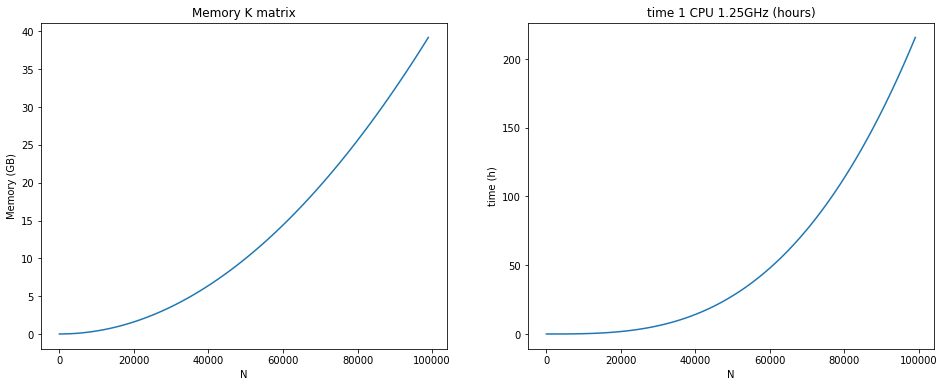

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = np.arange(0,10**5,1000)

size_element = 8 #bytes
Memory_GB = size_element*N**2/10**9/2

power_gpu_GHz = 1.25
operations_per_second_cpu = power_gpu_GHz*10**9 #1.25GHz
time_hours = (N**3/operations_per_second_cpu) / 3600

fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(N,Memory_GB)
ax[1].plot(N,time_hours)
ax[0].set_xlabel("N")
ax[0].set_ylabel("Memory (GB)")
ax[0].set_title("Memory K matrix")
ax[1].set_xlabel("N")
ax[1].set_title("CPU %.2fGHz"%power_gpu_GHz)
_=ax[1].set_ylabel("Time (hours)")


## Solutions if we have *Big* data?

* Discard data use only a subset. **Subset of Data approach (SoD)**.
* Use another regression method that scales better:
  * Neural networks
  * Random forest
  * Gradient boosting machines...



<center>
<img src="https://media.giphy.com/media/26uf8nlYOhMtF63zW/giphy.gif" width=300/>
*Sneak out* approaches
</center>

<span id="SoR"></span>
## Subset of Regressors (SoR)
Instead of **represent** $f^*$ with the $N$ points $X$ **represent** it using only $M << N$ points $X_u=\{x_{ui}\}_{i=1}^M\subset X$:
$$
\color{blue}{f^*}(x) = \sum_{i=1}^{N} \color{blue}{\alpha_i} k(\color{blue}{x_i},x) = \overbrace{k(x,\color{blue}X)}^{1 \times N}\underbrace{\color{blue}\alpha}_{^{N \times 1}}
$$

$$
\color{red}{f^*}(x) = \sum_{i=1}^{M} \color{red}{\alpha_{ui}} k(\color{red}{x_{ui}},x) = \overbrace{k(x,\color{red}{X_u})}^{1 \times M}\underbrace{\color{red}{\alpha_u}}_{^{M \times 1}}
$$

* **Spoiler**: This leads to Nystrom approximation: [[Williams and Seeger 2000]](https://papers.nips.cc/paper/1866-using-the-nystrom-method-to-speed-up-kernel-machines)

## How does $J(\color{red}{f^*})$ changes?

$$
\begin{aligned}
J(\color{blue}{f^*}) &= \sum_{i=1}^N \big(\color{blue}{f^*}(x_i) - y_i \big)^2 + \lambda\|\color{blue}{f^*}\|^2_{\mathcal{F}} \\
  &= \sum_{i=1}^N \big(k(x_i,\color{blue}{X})\color{blue}{\alpha} - y_i \big)^2 + \lambda\sum_{i=1}^N \sum_{j=1}^N \color{blue}{\alpha_i} \color{blue}{\alpha_j} k(\color{blue}{x_i},\color{blue}{x_j}) \\
  &= \|\color{blue}K \color{blue}\alpha - y \|^2 + \lambda\color{blue}\alpha^t \color{blue}K \color{blue}\alpha = J(\color{blue}\alpha)
\end{aligned}
$$


$$
\begin{aligned}
J(\color{red}{f^*}) &= \sum_{i=1}^N \big(\color{red}{f^*}(x_i) - y_i \big)^2 + \lambda\|\color{red}{f^*}\|^2_{\mathcal{F}} \\
  &= \sum_{i=1}^N \big(k(x_i,\color{red}{X_u})\color{red}{\alpha_u} - y_i \big)^2 + \lambda\sum_{i=1}^M \sum_{j=1}^M \color{red}{\alpha_{ui}} \color{red}{\alpha_{uj}} k(\color{red}{x_i},\color{red}{x_j}) \\
  &= \|k(X_f,\color{red}{X_u}) \color{red}{\alpha_u} - y \|^2 + \lambda\color{red}{\alpha_u}^t \color{red}{K_{uu}} \color{red}{\alpha_u} = J(\color{red}{\alpha_u})
\end{aligned}
$$

$$
k(X_f,X_u)=K_{fu} = \begin{pmatrix} 
k(x_1,x_{u_1}) & k(x_1,x_{u_2}) &...& k(x_1,x_{u_M}) \\
k(x_2,x_{u_1}) & k(x_2,x_{u_2}) &...& k(x_2,x_{u_M}) \\
\vdots & \vdots & \ddots &\vdots \\
k(x_N,x_{u_1}) & k(x_N,x_{u_2}) &...& k(x_N,x_{u_M}) \\
\end{pmatrix} \in \mathbb{R}^{N\times M}
$$

<span id="SoRSolution"></span>
## SoR solution

Finding the $\color{red}{\alpha^*}$ that $\nabla_{\color{red}\alpha}J(\color{red}{\alpha^*}) = 0$ leads to:

$$
\begin{aligned}
\color{red}{\alpha_u^*} &= \big(K_{uf} K_{fu} + \lambda  K_{uu}\big)^{-1}K_{uf}y\\
 &= K_{uu}^{-1}K_{uf}\big(\underbrace{K_{fu}K_{uu}^{-1}K_{uf}}_{Q_{ff}} + \lambda I\big)^{-1}y
 \end{aligned}
$$


The Risk $J$ at this $\color{red}{\alpha_u^*}$ is:
$$
\begin{aligned}
J(\color{red}{f^*}) = J(\color{red}{\alpha_u^*}) &= \lambda y^t\big(\overbrace{K_{fu}K_{uu}^{-1}K_{uf}}^{Q_{ff}}+ \lambda I\big)^{-1} y \\
&= y^t \left( I -K_{fu}\Big(K_{uu}^{-1} + K_{uf}K_{fu}\Big)^{-1}K_{uf} \right)y 
\end{aligned}
$$

**Matrix Inversion Lemma** to see the equivalences!

## Find the optimal $\color{red}{\alpha_u^*}$

$$
\begin{aligned}
J(\color{red}{\alpha_u}) &= \|K_{fu} \color{red}{\alpha_u} - y \|^2 + \lambda\color{red}{\alpha_u}^t K_{uu} \color{red}{\alpha_u} \\
 &= (K_{fu}\alpha -y)^t (K_{fu}\color{red}{\alpha_u} -y) + \lambda\color{red}{\alpha_u}^t K_{uu} \color{red}{\alpha_u}\\
 &= \color{red}{\alpha_u}^t K_{uf} K_{fu}\color{red}{\alpha_u} -2 \color{red}{\alpha_u}^t K_{uf} y + y^t y + \lambda\color{red}{\alpha_u}^t K_{uu} \color{red}{\alpha_u}
 \end{aligned}
$$

$$
\begin{aligned}
\nabla_\alpha J(\color{red}{\alpha_u}) &= 2 K_{uf} K_{fu}\color{red}{\alpha_u} -2 K_{uf} y + 2\lambda K_{uu} \color{red}{\alpha_u}  \\
&= 2 \big(  K_{uf} K_{fu}\color{red}{\alpha_u} - K_{uf}y + \lambda K_{uu}\color{red}{\alpha_u}\big)  \\
&= 2 \big( (K_{uf} K_{fu} + \lambda  K_{uu})\color{red}{\alpha_u} - K_{uf}y \big) 
\end{aligned}
$$

$\nabla_\alpha J(\color{red}{\alpha_u}) = 0$ $\implies$ $(K_{uf} K_{fu} + \lambda  K_{uu})\color{red}{\alpha_u} - K_{uf}y = 0$  $\implies$ 

$$
\begin{aligned}
\color{red}{\alpha_u^*} &= \big(K_{uf} K_{fu} + \lambda  K_{uu}\big)^{-1}K_{uf}y\\
\color{red}{\alpha_u^*} &= K_{uu}^{-1}K_{uf}\big(\underbrace{K_{uf}K_{uu}^{-1} K_{fu}}_{Q_{ff}} + \lambda I\big)^{-1}y
\end{aligned}
$$

Last step: [**Matrix Inversion Lemma**](#MIL).

<span id="MIL"></span>
## Matrix Inversion Lemma

$$
 \Big(Z + UWV^t\Big)^{-1} = Z^{-1} -Z^{-1} U\Big(W^{-1} + V^tZ^{-1}U\Big)^{-1}V^tZ^{-1} 
$$
$Z$ and $W$ are square invertible matrices. $V$ and $U$ don't need to be.

In our problem:
$$
\begin{aligned}
\Big(\lambda I + \underbrace{K_{fu}K_{uu}K_{fu}^t}_{Q_{ff}}\Big)^{-1} &= \lambda^{-1} I -\lambda^{-1}Id K_{fu}\Big(K_{uu}^{-1} + K_{fu}^tI\lambda^{-1}K_{fu}\Big)^{-1}K_{fu}^tI\lambda^{-1} \\ 
  &= \lambda^{-1} I -\lambda^{-1}K_{fu}\Big(K_{uu}^{-1} + K_{uf}K_{fu}\Big)^{-1}K_{uf} \\ 
 \end{aligned}
$$


## $J(\color{red}{\alpha_u^*}) = Error(\color{red}{\alpha_u^*}) + Reg(\color{red}{\alpha_u^*})$

What is the $Error(\color{red}{\alpha_u^*})$:

$$
\begin{aligned}
Error(\color{red}{\alpha_u^*}) &= \|K_{fu} \color{red}{\alpha_u^*} - y \|^2 \\
 &= \Big\|\overbrace{K_{fu}K_{uu}^{-1}K_{uf}}^{Q_{ff}} \Big(Q_{ff} + \lambda  I\Big)^{-1}y - y \Big\|^2  \\
  &= \lambda^2\left\| \left(Q_{ff} + \lambda  I\right)^{-1}y  \right\|^2 \text{ Trick add and substract }\lambda I\\
  &= \lambda^2\left\| \color{red}{\alpha_u^*}  \right\|^2 
\end{aligned}
$$
**Watch out**: if $\lambda=0$ $\implies$ $Q_{ff}$ can't be inverted.

## $J(\color{red}{\alpha_u^*}) = Error(\color{red}{\alpha_u^*}) + Reg(\color{red}{\alpha_u^*})$

What is the regularization term of $Reg(\color{red}{\alpha_u^*})$:

$$
\begin{aligned}
\frac{Reg(\color{red}{\alpha_u^*})}{\lambda} &= \color{red}{\alpha_u^*}^t K_{uu}\color{red}{\alpha_u^*} \\
&=  \left(Q_{ff} + \lambda I\right)^{-1}K_{fu}K_{uu}^{-1}\cancel{K_{uu}}\cancel{K_{uu}^{-1}}K_{uf}\left(Q_{ff} + \lambda I\right)^{-1} \\
&=  \left(Q_{ff} + \lambda I\right)^{-1}Q_{ff}\left(Q_{ff} + \lambda I\right)^{-1} \\
&= y^t(Q_{ff}+\lambda I)^{-1} y -\lambda\|\color{red}{\alpha_u^*} \|^2 \\
Reg(\color{red}{\alpha_u^*}) &= \lambda y^t\left(Q_{ff}+\lambda I\right)^{-1} y -\lambda^2\|\color{red}{\alpha_u^*} \|^2
\end{aligned}
$$

## $J(\color{red}{\alpha_u^*}) = Error(\color{red}{\alpha_u^*}) + Reg(\color{red}{\alpha_u^*})$

Putting things together:

$$
\begin{aligned}
J(\color{red}{f^*}) = J(\color{red}{\alpha_u^*}) &= Error(\color{red}{\alpha_u^*}) + Reg(\color{red}{\alpha_u^*}) \\
&= \lambda y^t\left(Q_{ff}+ \lambda I\right)^{-1} y \\
&= \cancel{\lambda} y^t \left(\cancel{\lambda^{-1}} I -\cancel{\lambda^{-1}}K_{fu}\Big(K_{uu}^{-1} + K_{uf}K_{fu}\Big)^{-1}K_{uf} \right)y \\ 
&= y^t \left( I -K_{fu}\Big(K_{uu}^{-1} + K_{uf}K_{fu}\Big)^{-1}K_{uf} \right)y 
\end{aligned}
$$

Last step: **Matrix inversion lemma**.

## SoR solution

How do we make predictions for new $\color{purple}x$:
$$
\color{red}{f^*}(\color{purple}x) = \sum_{i=1}^M\color{red}{\alpha_{ui}^*} k(x_{ui},\color{purple}x) = \overbrace{k(\color{purple}x,X_u)}^{1 \times M}\underbrace{\color{red}{\alpha_{ui}^*}}_{^{M \times 1}}
$$

Computational complexity: $\mathcal{O}(NM^2)$. 

$\lambda$ and parameters of the kernel $\Theta$ by **cross-validation**.

<span id="okrr"></span>
## Optimized KRR (OKRR)$^*$

We will define again $\color{green}{f^*}$ depending on a set of $M$ points $X_u=\{x_{ui}\}_{i=1}^M$. **But** do not restrict to $X_u\subset X$. 

$\color{green}{X_u}$ are **free variables in the input space**.

$$
\color{green}{f^*}(x) = \sum_{i=1}^{M} \color{green}{\alpha_{ui}} k(\color{green}{x_{ui}},x) = \overbrace{k(x,\color{green}{X_u})}^{1 \times M}\underbrace{\color{green}{\alpha_u}}_{^{M \times 1}}
$$



The risk $J$ would be:
$$
\begin{aligned}
J(\color{green}{f^*}) &= \sum_{i=1}^N \big(k(x_i,\color{green}{X_u})\color{green}{\alpha_u} - y_i \big)^2 + \lambda\sum_{i=1}^M \sum_{j=1}^M \color{green}{\alpha_{ui}} \color{green}{\alpha_{uj}} k(\color{green}{x_i},\color{green}{x_j}) \\
&= \|k(X_f,\color{green}{X_u}) \color{green}{\alpha_u} - y \|^2 + \lambda\color{green}{\alpha_u}^t \color{green}{K_{uu}} \color{green}{\alpha_u}= J(\color{green}{\alpha_u},\color{green}{X_u})
\end{aligned}
$$

<center>
$J(\color{green}{\alpha_u},\color{green}{X_u})$ is not convex w.r.t. $\color{green}{\alpha_u}$ and $\color{green}{X_u}$! $\implies$ No close form solution for the optimal $\color{green}{\alpha_u^*}$ and $\color{green}{X_u^*}$.
</center>

<center>
<strong>Proposed Solution</strong>: Use iterative algorithms to minimize $J$.
</center>

<span id="GD"></span>
## Solution 0: gradient descent (GD)

$$
\begin{aligned}
\color{green}{X_u}(t+1) &= \color{green}{X_u}(t) + \epsilon \nabla_{\color{green}{X_u}} J(\color{green}{\alpha_u}(t),\color{green}{X_u}(t))\\
\color{green}{\alpha_u}(t+1) &= \color{green}{\alpha_u}(t) + \epsilon \nabla_{\color{green}{\alpha_u}} J(\color{green}{\alpha_u}(t),\color{green}{X_u}(t)) 
\end{aligned}
$$

Initialized with:
<center>
$\color{green}{X_u}(0) \subset X$ and $\color{green}{\alpha_u}(0) = \left(K_{uu}+\lambda I \right)^{-1}y_u$
</center>

<span id="SGD"></span>
## Solution 1: *Stochastic* gradient descent (SGD)

The same but computing **stochastic** estimates of the gradients $\nabla_{X_u}J$ and $\nabla_{\alpha_u}J$.

### What is SGD?

If our gradient is an expectation over all the data $\mathcal{D}=\{x_i,y_i\}_{i=1}^N$:
$$
\nabla_{\alpha}J(\alpha) = \frac{1}{N}\sum_{i=0}^N g(\alpha,x_i,y_i )
$$
Then if we take a *subset* $\mathcal{D}_{k} \subset \mathcal{D}$:

$$
\nabla_{\alpha}J(\alpha) \approx \frac{1}{K}\sum_{k=0}^K g(\alpha,x_k,y_k )
$$

SGD: same solution than gradient descent but using the approximate gradient.

$$
\begin{aligned}
\color{green}{X_u}(t+1) &= \color{green}{X_u}(t) + \epsilon \nabla_{\color{green}{X_u}} J(\color{green}{\alpha_u}(t),\color{green}{X_u}(t))\\
\color{green}{\alpha_u}(t+1) &= \color{green}{\alpha_u}(t) + \epsilon \nabla_{\color{green}{\alpha_u}} J(\color{green}{\alpha_u}(t),\color{green}{X_u}(t)) 
\end{aligned}
$$
    

Computational complexity does not depend on $N$!

The loss $J$ can be decomposed for stochastic gradient descent:

$$
\begin{aligned}
\nabla_{\color{green}{\alpha_u}} J(\color{green}{\alpha_u},\color{green}{X_u}) &= \sum_{i=0}^N 2\left(k(x_i,\color{green}{X_u})\color{green}{\alpha_u} - y_i\right) k(x_i,\color{green}{X_u}) + 2\lambda k(\color{green}{X_u},\color{green}{X_u})\color{green}{\alpha_u} \\
\frac{\nabla_{\color{green}{\alpha_u}} J(\color{green}{\alpha_u},\color{green}{X_u})}{2N} &= \frac{1}{N}\sum_{i=0}^N \left(k(x_i,\color{green}{X_u})\color{green}{\alpha_u} - y_i\right) k(x_i,\color{green}{X_u}) +\frac{\lambda}{N} k(\color{green}{X_u},\color{green}{X_u})\color{green}{\alpha_u} \\
 &= \mathbb{E}_{(x,y)\sim \mathcal{D}} \left[(k(x,\color{green}{X_u})\color{green}{\alpha_u} - y) k(x,\color{green}{X_u})\right] +\frac{\lambda}{N} k(\color{green}{X_u},\color{green}{X_u})\color{green}{\alpha_u}
\end{aligned}
$$

Compute the *stochastic gradient*: expectations using small subsets of $\mathcal{D}$.

$$
\begin{aligned}
\nabla_{\color{green}{X_u}} J(\color{green}{\alpha_u},\color{green}{X_u}) &= \sum_{i=0}^N 2\left(k(x_i,\color{green}{X_u})\color{green}{\alpha_u} - y_i\right) \nabla_{\color{green}{X_u}}k(x_i,\color{green}{X_u})\color{green}{\alpha_u} + \lambda \color{green}{\alpha_u}^t \nabla_{\color{green}{X_u}}k(\color{green}{X_u},\color{green}{X_u})\color{green}{\alpha_u} \\
\frac{\nabla_{\color{green}{X_u}} J(\color{green}{\alpha_u},\color{green}{X_u})}{2N} &= \frac{1}{N}\sum_{i=0}^N \left(k(x_i,\color{green}{X_u})\color{green}{\alpha_u} - y_i\right) \nabla_{\color{green}{X_u}}k(x_i,\color{green}{X_u})\color{green}{\alpha_u} + \frac{\lambda}{2N} \color{green}{\alpha_u}^t \nabla_{\color{green}{X_u}}k(\color{green}{X_u},\color{green}{X_u})\color{green}{\alpha_u} \\
 &=  \mathbb{E}_{(x,y)\sim \mathcal{D}} \left[\left(k(x_i,\color{green}{X_u})\color{green}{\alpha_u} - y_i\right) \nabla_{\color{green}{X_u}}k(x_i,\color{green}{X_u})\color{green}{\alpha_u}\right] + \frac{\lambda}{2N} \color{green}{\alpha_u}^t \nabla_{\color{green}{X_u}}k(\color{green}{X_u},\color{green}{X_u})\color{green}{\alpha_u}
\end{aligned}
$$

<span id="alpha_exact"></span>
## Solution 2: Exact $\color{green}{\alpha_u^*}$

Recall the SoR solution 
$$
\begin{aligned}
\color{red}{\alpha_u^*} &= \big(K_{uf} K_{fu} + \lambda  K_{uu}\big)^{-1}K_{uf}y\\
 &= K_{uu}^{-1}K_{uf}\big(\underbrace{K_{fu}K_{uu}^{-1}K_{uf}}_{Q_{ff}} + \lambda I\big)^{-1}y
 \end{aligned}
$$
The value of the risk at the optimal $\color{red}{\alpha_u^*}$:
$$
\begin{aligned}
J(\color{red}{f^*}) = J(\color{red}{\alpha_u^*}) &= \lambda y^t\big(\overbrace{K_{fu}K_{uu}^{-1}K_{uf}}^{Q_{ff}}+ \lambda I\big)^{-1} y \\
&= y^t \left( I -K_{fu}\Big(K_{uu}^{-1} + K_{uf}K_{fu}\Big)^{-1}K_{uf} \right)y 
\end{aligned}
$$

## Solution 2: Exact $\color{green}{\alpha_u^*}$

We can minimize the optimal risk w.r.t. **only** $\color{green}{X_u}$:

$$
\begin{aligned}
\hat{J}(\color{green}{X_u}) &= J(\color{green}{\alpha_u^*},\color{green}{X_u}) = \lambda y^t\big(\overbrace{K(X,\color{green}{X_u})\color{green}{K_{uu}}^{-1}K(\color{green}{X_u},X)}^{\color{green}{Q_{ff}}}+ \lambda I\big)^{-1} y \\
&= y^t \left( I -K(X,\color{green}{X_u})\Big(\color{green}{K_{uu}}^{-1} + K(\color{green}{X_u},X)K(X,\color{green}{X_u})\Big)^{-1}K(\color{green}{X_u},X) \right)y  \\
\end{aligned}
$$


Algorithm:
$$
\color{green}{X_u}(t+1) = \color{green}{X_u}(t) + \epsilon \nabla_{\color{green}{X_u}} \hat{J}(\color{green}{X_u}(t))
$$

Using as starting point: $\color{green}{X_u}(0) \subset X$.

Computational complexity of computing the gradient $\nabla_{\color{green}{X_u}}\hat{J}$ is: $\mathcal{O}(DNM^2)$ [[Quiñonero-Candela 2005]](http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf).

## OKRR Predictions

How do we make predictions for new $\color{purple}x$:
$$
\color{green}{f^*}(\color{purple}x) = \sum_{i=1}^M\color{green}{\alpha_{ui}^*} k(\color{green}{x_{ui}^*},\color{purple}x) = \overbrace{k(\color{purple}x,\color{green}{X_u^*})}^{1 \times M}\underbrace{\color{green}{\alpha_{ui}^*}}_{^{M \times 1}}
$$


## Summary from KRR to OKRR

<center>
<img src="https://media.giphy.com/media/PvxHiFvaPweU8/giphy.gif"/ width="300">
</center>


* __KRR__ solution is intractable for Big Data.
* __SoR/Nystrom__: simple solution to **trade off** error vs computational tractability: subset $\color{red}{X_u}$ of size $M$.
* __Optimized KRR$^*$__: two approaches (SGD and $\color{green}{\alpha_u^*}$-exact) to reduce the error while maintaining tractability.

<span id="gp"></span>
## Gaussian Processes $\mathcal{GP}s$

$\mathcal{GP}s$ is a bayesian regression method that assumes that the outputs $y^*$ *given* the inputs $X^*$ follows a multidimensional gaussian distribution $y^*\mid X^* \sim \mathcal{N}(0,k(X^*,X^*)+\sigma^2 I)$.

When we *observe* some data $\mathcal{D}=(X,y)$:
1. We can compute how _likely_ is this data according to this model (**Marginal likelihood**):
$$
p(y \mid X) = \mathcal{N}( 0,k(X,X)+\sigma^2 I) = \left(\sqrt{(2\pi)^k |K+\sigma^2 I|}\right)^{-1} \exp \left(\frac{-1}{2} y^t(K+\sigma^2)^{-1} y\right)
$$


2. we can update our probabilistic model to incorporate this observations $y^*\mid X^*,X,y$:
$$
\begin{aligned}
p(y^*\mid X^*,X,y) = \mathcal{N}\Big(&\overbrace{k(X^*,X)}^{K_{*f}}\left(K+\sigma^2\right)^{-1}y,\\
 &  \underbrace{k(X^*,X^*)}_{K_{**}} +\sigma^2 I -\left(K_{*f}\left(K+\sigma^2I\right)^{-1}K_{*f}\right)\Big)
\end{aligned}
$$

The *mean function* of this probabilistic model is the same as the KRR prediction!

## Joint prior

By assumption, the model for the data is:
$$
p(y^*,y\mid X^*,X) = \mathcal{N}\left(0,\begin{pmatrix} k(X,X)+\sigma^2 I & k(X,X^*) \\
k(X^*,X) &k(X^*,X^*)+\sigma^2 I \end{pmatrix}\right)
$$

So we can compute  the **conditional distribution** [wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions):
$$
\begin{aligned}
p(y^*\mid X^*,X,y) = \mathcal{N}\Big(&k(X^*,X)\left(K+\sigma^2\right)^{-1}y,\\
 &  k(X^*,X^*) +\sigma^2 I -k(X^*,X)\left(K+\sigma^2I\right)^{-1}k(X,X^*)\Big)
\end{aligned}
$$

<span id="gpvskrr"></span>
## $\mathcal{GP}s$ vs KRR

1. $\mathcal{GP}s$: $\sigma^2$ and the parameters of the kernel ($\Theta$) optimized using **gradient descent on the marginal likelihood**. 
$$
p(y \mid X) = \mathcal{N}( 0,k(X,X)+\sigma^2 I) = \left(\sqrt{(2\pi)^k |K+\sigma^2 I|}\right)^{-1} \exp \left(\frac{-1}{2} y^t(K+\sigma^2)^{-1} y\right) = \color{orange}{h(\Theta,\sigma^2)}
$$
Evaluate the gradient has a cost $\mathcal{O}(N^3)$.
2. Same parameters of the kernel, $\sigma^2=\lambda$ $\implies$ **the mean of the $\mathcal{GP}$ is the same as the KRR solution**.
3. KRR uses cross-validation which is computationally more expensive.
4. Is marginal likelihood better or worse than cross-validation? [[Bachoc 2013](http://www.sciencedirect.com/science/article/pii/S0167947313001187), [Sundarajan and Keerthi 2001](http://www.mitpressjournals.org/doi/10.1162/08997660151134343)].

<span id="spgp"></span>
## Sparse Gaussian Processes $\mathcal{SPGP}s$

* They modify the probabilistic model in a way that the problem is tractable when $N$ is big.
* Some approaches rely on the idea of taking a subset $X_u\subset X$ called **pseudo-inputs**.
* Other approaches rely on the random fourier features  estimation of the kernel.

Many proposals over the last years:

In [3]:
nombres = {'snelson_sparse_2006': "Propose to optimize pseudo-inputs (FITC)",
           'seeger_fast_2003': "SoR/DTC + search best pseudo-inputs in X",
           "williams_using_2000": "Nystrom",
           "quinonero-candela_unifying_2005": "Unifying Framework",
           "lazaro-gredilla_sparse_2010": "Random Fourier Features: (SSGP)",
           "csato_sparse_2002": "SoR/DTC + search best pseudo-inputs in X",
           "titsias_variational_2009": "Variational free energy approach (VFE)",
           'hensman_gaussian_2013': "Stochastic gradient descent on VFE: (SVI)",
           "gal_improving_2015": "Stochastic gradient descent on SSGP",
           "matthews_sparse_2015": "Titsias VFE alternative derivation",
           "bauer_understanding_2016": "VFE vs FITC",
           'bui_unifying_2017': "New framework using expectation propagation (EP)"
          }

In [4]:
from IPython.display import HTML
from pybtex.database.input import bibtex
parser = bibtex.Parser()
bib_data = parser.parse_file('Sparse_GP.bib')

def make_cita(bibentry):
    text_latex = bibentry.rich_fields.get('author')
    persons_print =[person.split(",")[0] for person in str(text_latex).split("and ")]
    #print(persons_print,len(persons_print))
    if len(persons_print)==1:
        cita = persons_print[0]
    elif len(persons_print)==2:
        cita = " and ".join(persons_print) 
    else:
        cita = persons_print[0]+" et al."

    cita+=" "+ str(bibentry.rich_fields.get('year'))
    return cita

string = ""
for bibentry_key in sorted(bib_data.entries.keys(),key=lambda x: bib_data.entries[x].fields["year"]):
    bibentry = bib_data.entries[bibentry_key]
    # bibentry.rich_fields.get('title')
    if bibentry_key in nombres:
        #print(make_cita(bibentry),"--->",nombres[bibentry_key])
        string+="<a href='%s'>[%s]</a>: <span>%s</span></br>"%(bibentry.fields["url"],make_cita(bibentry),nombres[bibentry_key])

HTML(string)

## Sparse approximations [[Quiñonero-Candela 2005]](http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf)

We introduce $u$ variable that is the noise-free value of the pseudo-inputs $X_u$. 
If we are given $u$ for the standard $\mathcal{GP}$ the posterior is:
$$
\begin{aligned}
p(y \mid u,X_u,X) = \mathcal{N}(& \overbrace{k(X,X_u)}^{K_{fu}} \left(K_{uu}\right)^{-1} u,\\
& K_{ff} - K_{fu}K_{uu}^{-1}K_{uf} + \sigma^2 I )
\end{aligned}
$$

$\color{red}{SoR/DTC}$ approximations:
$$
\begin{aligned}
p_{\color{red}{SoR/DTC}}(y \mid u,X_u,X) = \mathcal{N}(& K_{fu} \left(K_{uu}\right)^{-1} u,\\
& \color{red}{0} + \sigma^2 I )
\end{aligned}
$$

$\color{blue}{FITC}$ approximations:
$$
\begin{aligned}
p_{\color{blue}{FITC}}(y \mid u,X_u,X) = \mathcal{N}(& K_{fu} \left(K_{uu}\right)^{-1} u,\\
& \color{blue}{diag\Big[K_{ff} - \underbrace{K_{fu}K_{uu}^{-1}K_{uf}}_{Q_{ff}}\Big]} + \sigma^2 I )
\end{aligned}
$$

## Sparse approximations: ML
To compute the **Marginal Likelihood** we integrate out $u$. 
$$
p(y \mid X_u,X) = \int p(y \mid u,X_u,X) \overbrace{p(u \mid X_u)}^{\mathcal{N}(0,K_{uu})} du = \mathcal{N}(0,K+\sigma^2I)
$$

If we use $\color{red}{SoR/DTC}$ approximation:

$$
p_{\color{red}{SoR/DTC}}(y \mid X_u,X) = \int p_{\color{red}{SoR/DTC}}(y \mid u,X_u,X) \overbrace{p(u \mid X_u)}^{\mathcal{N}(0,K_{uu})} du = \mathcal{N}(0,\color{red}{\underbrace{K_{fu}K_{uu}^{-1}K_{uf}}_{Q_{ff}}}+\sigma^2I)
$$

If we use $\color{blue}{FITC}$ approximation:

$$
p_{\color{blue}{FITC}}(y \mid X_u,X) = \int p_{\color{blue}{FITC}}(y \mid u,X_u,X) \overbrace{p(u \mid X_u)}^{\mathcal{N}(0,K_{uu})} du = \mathcal{N}(0,\color{blue}{\underbrace{K_{fu}K_{uu}^{-1}K_{uf}}_{Q_{ff}} - {diag}\big[K_{ff} -Q_{ff}\big]}+\sigma^2I)
$$

## Sparse approximations: Posterior

Normal $\mathcal{GP}$
$$
\begin{aligned}
p_{\mathcal{GP}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&K_{*f}\left(K_{ff}+\sigma^2I\right)^{-1}y,\\
 &  K_{**} +\sigma^2 I -\left(K_{*f}\left(K_{ff}+\sigma^2I\right)^{-1}K_{*f}\right)\Big)
\end{aligned}
$$

If we use $\color{red}{SoR}$ approximation:

$$
\begin{aligned}
p_{\color{red}{SoR}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&\color{red}{Q_{*f}}\left(\color{red}{Q_{ff}}+\sigma^2I\right)^{-1}y,\\
 &  \color{red}{Q_{**}} +\sigma^2 I -\left(\color{red}{Q_{*f}}\left(\color{red}{Q_{ff}}+\sigma^2I\right)^{-1}\color{red}{Q_{*f}}\right)\Big)
\end{aligned}
$$

If we use $\color{purple}{DTC}$ approximation:

$$
\begin{aligned}
p_{\color{purple}{DTC}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&\color{purple}{Q_{*f}}\left(\color{purple}{Q_{ff}}+\sigma^2I\right)^{-1}y,\\
 &  K_{**} +\sigma^2 I -\left(\color{purple}{Q_{*f}}\left(\color{purple}{Q_{ff}}+\sigma^2I\right)^{-1}\color{purple}{Q_{*f}}\right)\Big)
\end{aligned}
$$

## Joint model
To compute the posterior we are assuming the following *joint priors*.

We recall the join model for the normal $\mathcal{GP}$:
$$
p_{\mathcal{GP}}(y^*,y\mid X^*,X) = \mathcal{N}\left(0,\begin{pmatrix} K_{ff}+\sigma^2 I & K_{f*} \\
K_{*f} I &K_{**}+\sigma^2 I \end{pmatrix}\right)
$$


For $\color{red}{SoR}$ this is the model that leads to the aforementioned posterior:
$$
p_{\color{red}{SoR}}(y^*,y\mid X^*,X) = \mathcal{N}\left(0,\begin{pmatrix} \color{red}{Q_{ff}}+\sigma^2 I & \color{red}{Q_{f*}} \\
\color{red}{Q_{*f}} I &\color{red}{Q_{**}}+\sigma^2 I \end{pmatrix}\right)
$$


For $\color{purple}{DTC}$ [[Csató and Opper 2002](http://www.mitpressjournals.org/doi/10.1162/089976602317250933), [Seeger et al. 2003](http://inverseprobability.com/publications/seeger-fast03.html)]:
$$
p_{\color{purple}{DTC}}(y^*,y\mid X^*,X) = \mathcal{N}\left(0,\begin{pmatrix} \color{purple}{Q_{ff}}+\sigma^2 I & \color{purple}{Q_{f*}} \\
\color{purple}{Q_{*f}} I &\color{purple}{K_{**}}+\sigma^2 I \end{pmatrix}\right)
$$

## Sparse approximations: Posterior

Normal $\mathcal{GP}$
$$
\begin{aligned}
p_{\mathcal{GP}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&K_{*f}\left(K_{ff}+\sigma^2I\right)^{-1}y,\\
 &  K_{**} +\sigma^2 I -\left(K_{*f}\left(K_{ff}+\sigma^2I\right)^{-1}K_{*f}\right)\Big)
\end{aligned}
$$

If we use $\color{blue}{FITC}$ approximation [[Snelson and Ghahramani 2006]](http://papers.nips.cc/paper/2857-sparse-gaussian-processes-using-pseudo-inputs.pdf):

$$
\begin{aligned}
p_{\color{blue}{FITC}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&\color{blue}{Q_{*f}}\left(\color{blue}{Q_{ff}}+ \color{blue}{diag\big[K_{ff} -Q_{ff}\big]}+\sigma^2I\right)^{-1}y,\\
 &  K_{**} +\sigma^2 I -\left(\color{blue}{Q_{*f}}\left(\color{blue}{Q_{ff}}+\color{blue}{diag\big[K_{ff} -Q_{ff}\big]}+\sigma^2I\right)^{-1}\color{blue}{Q_{*f}}\right)\Big)
\end{aligned}
$$

## Joint model
To compute the posterior we are assuming the following *joint priors*.

We recall the join model for the normal $\mathcal{GP}$:
$$
p_{\mathcal{GP}}(y^*,y\mid X^*,X) = \mathcal{N}\left(0,\begin{pmatrix} K_{ff}+\sigma^2 I & K_{f*} \\
K_{*f} I &K_{**}+\sigma^2 I \end{pmatrix}\right)
$$


For $\color{blue}{FITC}$:
$$
p_{\color{blue}{FITC}}(y^*,y\mid X^*,X) = \mathcal{N}\left(0,\begin{pmatrix} \color{blue}{Q_{ff}- {diag}\big[K_{ff} -Q_{ff}\big]}+\sigma^2 I & \color{blue}{Q_{f*}} \\
\color{blue}{Q_{*f}} I &\color{blue}{K_{**}}+\sigma^2 I \end{pmatrix}\right)
$$

## Sparse approximations: executive summary
1. Maximize the **ML** with gradient descent to find the $X_u$, $\Theta$ and $\sigma^2$:
$$
\begin{aligned}
p_{\color{purple}{DTC}}(y \mid X_u,X) =  \mathcal{N}(0,\color{purple}{Q_{ff}}+\sigma^2I) &= \left(\sqrt{(2\pi)^k |\color{purple}{Q_{ff}}+\sigma^2 I|}\right)^{-1} \exp \left(\frac{-1}{2} y^t(\color{purple}{Q_{ff}}+\sigma^2)^{-1} y\right)\\
&=h(\boldsymbol{X_u},\Theta,\sigma^2)
\end{aligned}
$$
2. Use this parameters parameters to make predictions with this formula:
$$
\begin{aligned}
p_{\color{purple}{DTC}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&\color{purple}{Q_{*f}}\left(\color{purple}{Q_{ff}}+\sigma^2I\right)^{-1}y,\\
 &  K_{**} +\sigma^2 I -\left(\color{purple}{Q_{*f}}\left(\color{purple}{Q_{ff}}+\sigma^2I\right)^{-1}\color{purple}{Q_{*f}}\right)\Big)
\end{aligned}
$$
Apply __Matrix inversion lemma__ to this formulas before applying them!

<span id="spgpvsokrr"></span>
##  $\mathcal{SPGP}s$ vs OKRR

1. OKRR with $\color{green}{\alpha_u^*}$ exact is _kind of similar_ to $\color{purple}{DTC}$:
$$
\begin{aligned}
-\log\left(p_{\color{purple}{DTC}}(y \mid X_u,X)\right) &= -\log \left ( \left(\sqrt{(2\pi)^k |\color{purple}{Q_{ff}}+\sigma^2 I|}\right)^{-1} \exp \left(\frac{-1}{2} y^t(\color{purple}{Q_{ff}}+\sigma^2 I)^{-1} y\right) \right) \\ 
%% &= \frac{1}{2} \log \left((2\pi)^k |\color{purple}{Q_{ff}}+\sigma^2 I|\right) + \frac{1}{2} y^t(\color{purple}{Q_{ff}}+\sigma^2 I)^{-1} y \\
&= \frac{k}{2} \log\left( 2\pi\right) + \frac{1}{2}\log\left|\color{purple}{Q_{ff}}+\sigma^2 I\right| + \frac{1}{2} y^t(\color{purple}{Q_{ff}}+\sigma^2 I)^{-1} y\\
\hat{J}(\color{green}{X_u}) &= J(\color{green}{\alpha_u^*},\color{green}{X_u}) = \lambda y^t\big(\color{green}{Q_{ff}}+ \lambda I\big)^{-1} y 
\end{aligned}
$$
2. $\mathcal{SPGP}s$ **cannot** be optimized using stochastic gradient descent. 
3. [[Hensman et al. 2013]](http://arxiv.org/abs/1309.6835): Variational approach to apply stochastic gradient descent to $\mathcal{SPGP}s$ (SVI).

<span id="vfe"></span>
## Variational Free Energy (VFE) [[Titsias 2009]](http://jmlr.csail.mit.edu/proceedings/papers/v5/titsias09a/titsias09a.pdf)

### Executive summary 
1. Take the $\color{purple}{DTC}$ approach. Then, instead of maximizing the **ML** to find the parameters ($X_u$, $\Theta$ and $\sigma^2$) maximize the **Variational bound**:
$$
\begin{aligned}
\mathcal{F}(X_u,\Theta,\sigma^2) =
%-\log \left ( \left(\sqrt{(2\pi)^k |\color{purple}{Q_{ff}}+\sigma^2 I|}\right)^{-1} \exp \left(\frac{-1}{2} y^t(\color{purple}{Q_{ff}}+\sigma^2 I)^{-1} y\right) \right) + \frac{1}{2\sigma^2}trace(K_{ff}-Q_{ff}) \\ 
%% &= \frac{1}{2} \log \left((2\pi)^k |\color{purple}{Q_{ff}}+\sigma^2 I|\right) + \frac{1}{2} y^t(\color{purple}{Q_{ff}}+\sigma^2 I)^{-1} y + \trace \\
 \frac{-k}{2} \log\left( 2\pi\right) + \frac{-1}{2}\log\left|Q_{ff}+\sigma^2 I\right| + \frac{-1}{2} y^t(Q_{ff}+\sigma^2 I)^{-1} y + \color{brown}{\frac{-1}{2\sigma^2}trace(K_{ff}-Q_{ff})}
\end{aligned}
$$
2. Once you have the optimal $X_u$, $\Theta$ and $\sigma^2$ use the $\color{purple}{DTC}$ posterior solution to make predictions:
$$
\begin{aligned}
p_{\color{brown}{VFE}}(y^* \mid X_u,y,X,X^*) = \mathcal{N}\Big(&\color{brown}{Q_{*f}}\left(\color{brown}{Q_{ff}}+\sigma^2I\right)^{-1}y,\\
 &  K_{**} +\sigma^2 I -\left(\color{brown}{Q_{*f}}\left(\color{brown}{Q_{ff}}+\sigma^2I\right)^{-1}\color{brown}{Q_{*f}}\right)\Big)
\end{aligned}
$$

<span id="results"></span>
## Preliminary Results
Different approaches try to minimize/maximize *similar* expressions. Which one is preferable? [[Bauer et al. 2016]](https://papers.nips.cc/paper/6477-understanding-probabilistic-sparse-gaussian-process-approximations)-> VFE vs FITC.

Comparison on IASI temperature retrieval data.

## Preliminary Results
* Varying the size $M$ of the pseudo-input set $X_u$

In [14]:
!cp ../../spgp_compairson.py .
!cp ../../load_data.py .
!cp ../../keras_okrr.py .

In [20]:
import spgp_compairson
import numpy as np

folder_jsons = "/mnt/erc_gonzalo/git/uv/sparse_gps/salida/"


todas_stats = spgp_compairson.read_jsons(folder_jsons)
cols_mostrar = ["M","N_train","metodo","mean_squared_error_train","mean_squared_error_test"]
SoD_stats = todas_stats[(todas_stats.metodo == "SoD") & (todas_stats.N_train == 50000)]
SoD_stats = SoD_stats.sort_values(by=["M","metodo"])

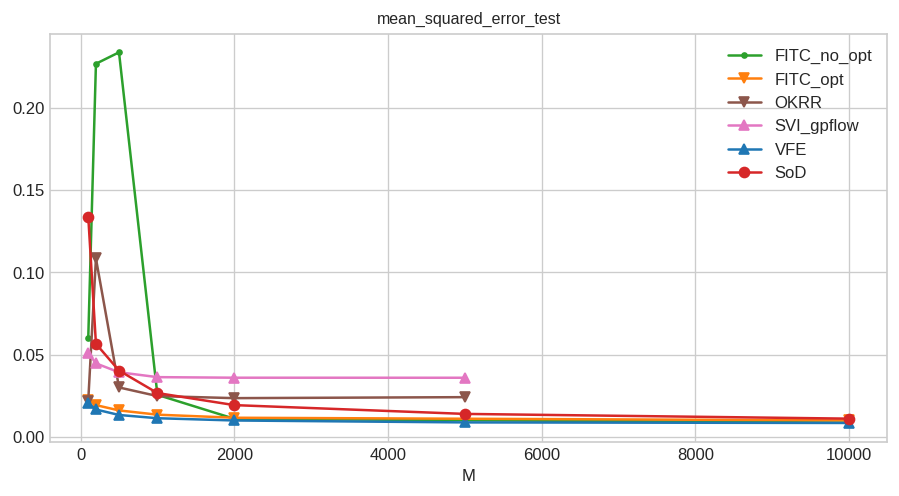

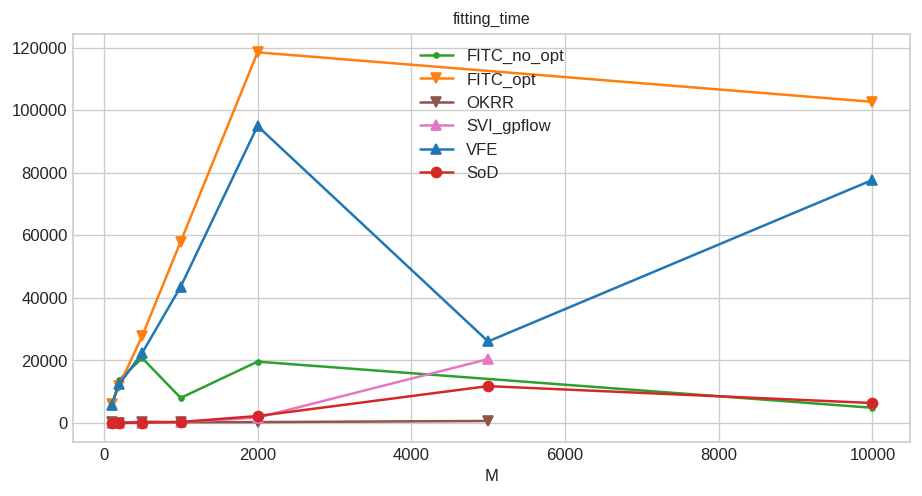

In [22]:
N_train_show = 30000
todas_stats_fixed_N = todas_stats[(todas_stats.N_train == N_train_show) & 
                                  (todas_stats.metodo != "FITC_no_opt_gpflow")& (todas_stats.metodo != "SVI")
                                 & (todas_stats.metodo != "SoD")]
todas_stats_fixed_N = todas_stats_fixed_N.sort_values(by=["M","metodo"])

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from load_data import update_rc_params
update_rc_params()

METHODS = spgp_compairson.METHODS + spgp_compairson.METHODS_2
metodo_color = dict([(m,"C%d"%i) for i,m in enumerate(METHODS)])
marker_color = dict([(m,mar) for m,mar in zip(METHODS,["^","v",".","o","+","v"]+["^","v",".","o","+","v"])])
def plot_curves(df,value="mean_squared_error_test",index="M",group_name="metodo",ax=None):
    ax = plt.gca()
    for name, group in df.groupby(group_name):
        line, =ax.plot(group[index],group[value],c=metodo_color[name],
                       marker=marker_color[name],label=name)
    ax.set_title(value)
    ax.set_xlabel(index)
    

def plot_curves_show(*args,**kwargs):
    plt.figure()
    plot_curves(*args,**kwargs)
    ax = plt.gca()
    value = kwargs["value"]
    line, =ax.plot(SoD_stats["M"],SoD_stats[value],c=metodo_color["SoD"],
                   marker=marker_color["SoD"],label="SoD")
    plt.legend()
    plt.show()
    

plot_curves_show(todas_stats_fixed_N,value="mean_squared_error_test")

plot_curves_show(todas_stats_fixed_N,value="fitting_time")

#plot_curves_show(todas_stats_fixed_N,value="mean_squared_error_train")
#todas_stats.head()

## Preliminary results
* Varying the ammount of training data $N$. (Fixed $M=500$)

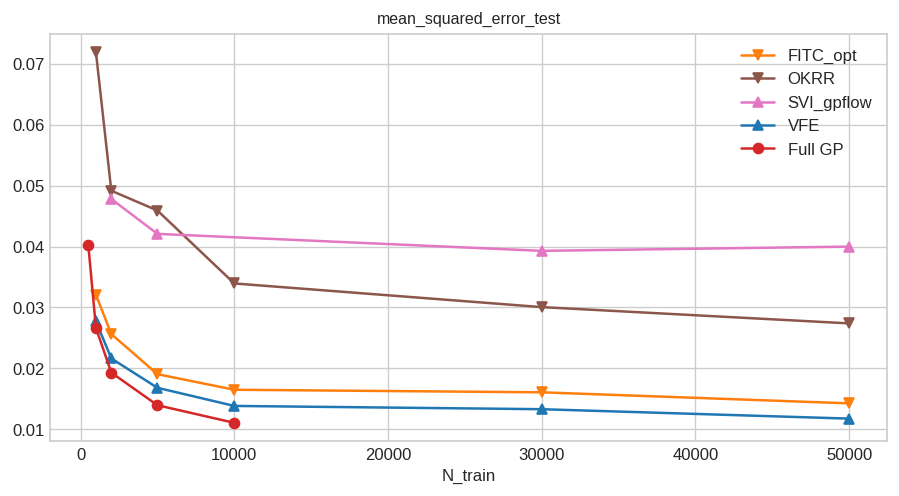

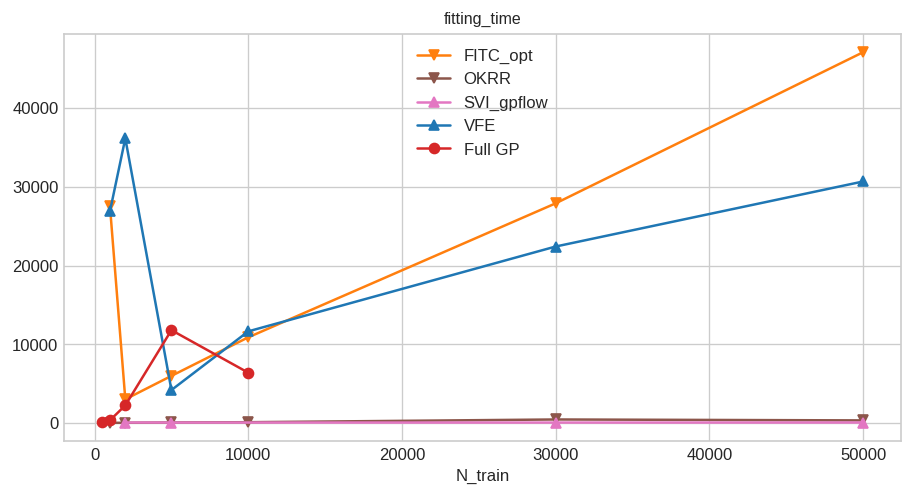

In [23]:
M_show = 500
todas_stats_fixed_M = todas_stats[(todas_stats.M == M_show) & (todas_stats.metodo != "SoD") & (todas_stats.metodo != "FITC_no_opt") &  (todas_stats.metodo != "SVI")]
todas_stats_fixed_M = todas_stats_fixed_M.sort_values(by=["N_train","metodo"])

def plot_curves_show_fixed_M(*args,**kwargs):
    plt.figure()
    plot_curves(*args,**kwargs)
    ax = plt.gca()
    value = kwargs["value"]
    SoD_stats_show = SoD_stats[SoD_stats.M >= M_show]
    line, =ax.plot(SoD_stats_show["M"],SoD_stats_show[value],c=metodo_color["SoD"],
                   marker=marker_color["SoD"],label="Full GP")
    plt.legend()
    plt.show()

plot_curves_show_fixed_M(todas_stats_fixed_M,index="N_train",value="mean_squared_error_test")

plot_curves_show_fixed_M(todas_stats_fixed_M,index="N_train",value="fitting_time")

## Conclusions
1. We can modify KRR to cope with big number of samples.
2. OKRR leads to different altough related cost function than $\mathcal{SPGP}s$.
